In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh, eigs
from qutip import Qobj, ptrace
from tqdm import tqdm
from itertools import product

In [2]:
# Get the machine precision for floating-point numbers
machine_epsilon = np.finfo(float).eps

print("Machine precision (epsilon):", machine_epsilon)

Machine precision (epsilon): 2.220446049250313e-16


In [13]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def pxp(N, pbc=False, sparse=True):
    """
    Constructs the Hamiltonian for the PXP model.
    
    Parameters:
        N (int): Number of spins.
        pbc (bool): Whether to use periodic boundary conditions.
        sparse (bool): Whether to return a sparse matrix.
    
    Returns:
        H (scipy.sparse.csr_matrix or np.ndarray): The Hamiltonian matrix.
    """
    # Identity matrix
    I = identity(2, format="csr") if sparse else np.eye(2)
    
    # Pauli matrices
    X = csr_matrix(pauli_x()) if sparse else pauli_x()
    Z = csr_matrix(pauli_z()) if sparse else pauli_z()
    P = csr_matrix(0.5 * (I + Z)) if sparse else 0.5 * (I - Z)
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64) if sparse else np.zeros((2**N, 2**N), dtype=np.float64)
    
    # Build the Hamiltonian for open boundary conditions
    for i in range(1, N-1):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, X, format="csr") if sparse else np.kron(term, X)
            elif j == i - 1 or j == i + 1:
                term = kron(term, P, format="csr") if sparse else np.kron(term, P)
            else:
                term = kron(term, I, format="csr") if sparse else np.kron(term, I)
        H += term

    # Add PBC terms if enabled
    if pbc:
        # First PBC term: coupling between the last and the first site
        term1 = 1
        for j in range(N):
            if j == 0:
                term1 = kron(term1, X, format="csr") if sparse else np.kron(term1, X)
            elif j == 1 or j == N - 1:
                term1 = kron(term1, P, format="csr") if sparse else np.kron(term1, P)
            else:
                term1 = kron(term1, I, format="csr") if sparse else np.kron(term1, I)
        H += term1

        # Second PBC term: coupling between the first and the last site
        term2 = 1
        for j in range(N):
            if j == 0 or j == N - 2:
                term2 = kron(term2, P, format="csr") if sparse else np.kron(term2, P)
            elif j == N - 1:
                term2 = kron(term2, X, format="csr") if sparse else np.kron(term2, X)
            else:
                term2 = kron(term2, I, format="csr") if sparse else np.kron(term2, I)
        H += term2

    return H

def r_state():
    """Returns the |r> state."""
    return np.array([[1], [0]])

def g_state():
    """Returns the |g> state."""
    return np.array([[0], [1]])

def neel_state(n_spins):  # allowed only by OBC if n_spins is odd
    """
    Constructs the Neel state for a given number of spins.
    
    Parameters:
        n_spins (int): Number of spins in the system.
    
    Returns:
        np.ndarray: The Neel state as a Kronecker product of |r> and |g> states.
    """
    state = r_state() if n_spins % 2 == 1 else g_state()
    for i in range(1, n_spins):
        if i % 2 == 0:
            state = np.kron(state, r_state())
        else:
            state = np.kron(state, g_state())
    return state

def antineel_state(n_spins): # allowed by both OBC and PBC
    """
    Constructs the anti-Neel state for a given number of spins.
    
    Parameters:
        n_spins (int): Number of spins in the system.
    
    Returns:
        np.ndarray: The anti-Neel state as a Kronecker product of |r> and |g> states.
    """
    state = g_state() if n_spins % 2 == 1 else r_state()
    for i in range(1, n_spins):
        if i % 2 == 0:
            state = np.kron(state, g_state())
        else:
            state = np.kron(state, r_state())
    return state

# define first the allowed states by rydberg blockade and then the PXP Hamiltonian in this subspace
def construct_pxp_hamiltonian(n_spins, boundary_condition="OBC"):
    """
    Constructs the PXP Hamiltonian matrix for a system of n_spins with specified boundary conditions,
    enforcing the Rydberg blockade constraint.
    
    Parameters:
        n_spins (int): Number of spins in the system.
        boundary_condition (str): "OBC" for open boundary conditions or "PBC" for periodic boundary conditions.

    Returns:
        H (numpy.ndarray): The PXP Hamiltonian matrix in the constrained subspace.
        basis (list): The list of allowed basis states in binary format.
    """
    # Generate all possible states in the full Hilbert space
    full_basis = list(product([0, 1], repeat=n_spins))
    
    # Filter states to respect the Rydberg blockade constraint
    allowed_basis = []
    for state in full_basis:
        if boundary_condition == "PBC":
            # Check that no two adjacent 1's exist, including across periodic boundaries
            if all(state[i] + state[(i + 1) % n_spins] <= 1 for i in range(n_spins)):
                allowed_basis.append(state)
        else:  # OBC
            # Check that no two adjacent 1's exist
            if all(state[i] + state[i + 1] <= 1 for i in range(n_spins - 1)):
                allowed_basis.append(state)
    
    # Map basis states to indices
    basis_size = len(allowed_basis)
    state_to_index = {state: idx for idx, state in enumerate(allowed_basis)}
    
    # Construct the full PXP Hamiltonian
    full_H = pxp(n_spins, pbc=(boundary_condition == "PBC"), sparse=False)
    
    # Project the full Hamiltonian onto the subspace defined by the allowed basis states
    H = np.zeros((basis_size, basis_size), dtype=float)
    for i, state_i in enumerate(allowed_basis):
        for j, state_j in enumerate(allowed_basis):
            idx_i = int("".join(map(str, state_i)), 2)
            idx_j = int("".join(map(str, state_j)), 2)
            H[i, j] = full_H[idx_i, idx_j]
    
    return H, allowed_basis

In [14]:
# Number of spins
n_spins = 4

# Construct the Hamiltonian
H = pxp(n_spins, pbc=True, sparse=False)

# Diagonalize the Hamiltonian
eigenvalues, eigenvectors = np.linalg.eig(H)

# Print the eigenvalues
print("Eigenvalues:")
print(eigenvalues)

# Print the eigenvectors
print("Eigenvectors:")
print(eigenvectors)

Eigenvalues:
[-2.44948974e+00  2.44948974e+00 -1.41421356e+00  1.41421356e+00
 -2.04692838e-16  1.10906517e-16  2.68642359e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Eigenvectors:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00 

In [19]:
#let's look at gs only

# Number of spins
n_spins = 8

# Construct the Hamiltonian
H = pxp(n_spins, pbc=True, sparse=True)

# ground state of H only + debugging partial trace

# Compute smallest eigenvalue and the corresponding eigenvector
min_eigenvalue, min_eigenvector = eigsh(H, k=1, which='SA')

print(f"Minimum eigenvalue: {min_eigenvalue}")
print(f"Corresponding eigenvector shape: {min_eigenvector.shape}")
#print(f"Corresponding eigenvector: {min_eigenvector}")

#Construct the density matrix
density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

print(f"Density matrix shape: {density_matrix.shape}")
#print(f"Density matrix: {density_matrix}")

density_matrix_qobj = Qobj(density_matrix, dims=[[2]*n_spins, [2]*n_spins])
print(f"qobj density matrix shape: {density_matrix_qobj.shape}")
#print(f"qobj density matrix: {density_matrix_qobj}")

# Trace out some qubits (keep other qubits)
keep_qubits = [1,2,3]  # Indices of qubits to keep
traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

# Convert the result back to a dense matrix if needed
traced_out_density_matrix_dense = traced_out_density_matrix.full()

print(type(traced_out_density_matrix))
print(type(traced_out_density_matrix_dense))

print(f"Traced out density matrix shape: {traced_out_density_matrix_dense.shape}")
#print(f"Traced out density matrix: {traced_out_density_matrix_dense}")

# Diagonalize the traced out density matrix
eigenvalues, eigenvectors = np.linalg.eigh(traced_out_density_matrix_dense)
#print(f"Eigenvalues of the traced out density matrix: {eigenvalues}")
#print(f"Eigenvectors of the traced out density matrix: {eigenvectors}")

# Print the minimum eigenvalue
min_eigenvalue = np.min(eigenvalues)
print(f"Minimum eigenvalue: {min_eigenvalue}")

Minimum eigenvalue: [-4.83095867]
Corresponding eigenvector shape: (256, 1)
Density matrix shape: (256, 256)
qobj density matrix shape: (256, 256)
<class 'qutip.core.qobj.Qobj'>
<class 'numpy.ndarray'>
Traced out density matrix shape: (8, 8)
Minimum eigenvalue: -2.0878799149260114e-25


In [21]:
# Set values with absolute value less than 1e-16 to zero
traced_out_density_matrix_dense[np.abs(traced_out_density_matrix_dense) < 1e-16] = 0

# Check if the matrix is Hermitian
is_hermitian = np.allclose(traced_out_density_matrix_dense, traced_out_density_matrix_dense.conj().T)

# Output the result
print("The density matrix is Hermitian." if is_hermitian else "The density matrix is not Hermitian.")

# Print the matrix
print(np.real(traced_out_density_matrix_dense))

# Print the eigenvalues
print("Eigenvalues:" ,eigenvalues)

# Print the rank of the density matrix
rank = np.linalg.matrix_rank(traced_out_density_matrix_dense)
print("Rank:", rank)

The density matrix is Hermitian.
[[ 4.68779788e-01 -2.21417043e-01 -3.01934917e-01  0.00000000e+00
  -2.21417043e-01  1.27203196e-01  1.22569735e-16  0.00000000e+00]
 [-2.21417043e-01  1.37543542e-01  1.35970726e-01  0.00000000e+00
   1.09646882e-01 -8.05178745e-02  0.00000000e+00  0.00000000e+00]
 [-3.01934917e-01  1.35970726e-01  1.96838335e-01  0.00000000e+00
   1.35970726e-01 -7.49454027e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.21417043e-01  1.09646882e-01  1.35970726e-01  0.00000000e+00
   1.37543542e-01 -8.05178745e-02  0.00000000e+00  0.00000000e+00]
 [ 1.27203196e-01 -8.05178745e-02 -7.49454027e-02  0.00000000e+00
  -8.05178745e-02  5.92947927e-02  0.00000000e+00  0.00000000e+00]
 [ 1.22569735e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0

In [29]:
Id = np.eye(2**len(keep_qubits))
commutator = np.dot(Id, traced_out_density_matrix_dense) - np.dot(traced_out_density_matrix_dense, Id)  
print(f"Commutator: {commutator}")

Commutator: [[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [30]:
# Number of spins
n_spins = 12

# Construct the Hamiltonian
H = pxp(n_spins, pbc=True, sparse=True)

# Diagonalize the Hamiltonian using eigsh for sparse matrices
#eigenvalues, eigenvectors = eigsh(H, k=H.shape[0]-1, which='SA')
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray()) #use exact diagonalization

# Print the eigenvalues
#print("Eigenvalues:")
#print(eigenvalues)

# Print the eigenvectors
#print("Eigenvectors:")
#print(eigenvectors)

In [31]:
'''# Construct the Neel state
neel = neel_state(n_spins).flatten()

# Compute the fidelity of each eigenvector with respect to the Neel state
fidelities = []
for i in range(eigenvectors.shape[1]):
    fidelity = np.abs(np.dot(neel.conj(), eigenvectors[:, i]))**2
    fidelities.append(fidelity)

# Plot the log base 10 of these fidelities as a function of the eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, np.log10(fidelities), 'o')
plt.xlabel('Eigenvalues')
plt.ylabel('Log10(Fidelity)')
plt.title('Log10(Fidelity) of Eigenvectors with respect to Neel State')
plt.grid(True)
plt.show()'''

"# Construct the Neel state\nneel = neel_state(n_spins).flatten()\n\n# Compute the fidelity of each eigenvector with respect to the Neel state\nfidelities = []\nfor i in range(eigenvectors.shape[1]):\n    fidelity = np.abs(np.dot(neel.conj(), eigenvectors[:, i]))**2\n    fidelities.append(fidelity)\n\n# Plot the log base 10 of these fidelities as a function of the eigenvalues\nplt.figure(figsize=(10, 6))\nplt.plot(eigenvalues, np.log10(fidelities), 'o')\nplt.xlabel('Eigenvalues')\nplt.ylabel('Log10(Fidelity)')\nplt.title('Log10(Fidelity) of Eigenvectors with respect to Neel State')\nplt.grid(True)\nplt.show()"

In [32]:
'''# Construct the Neel state
neel = neel_state(n_spins).flatten()

# Compute the fidelity of each eigenvector with respect to the Neel state
fidelities = []
for i in range(eigenvectors.shape[1]):
    fidelity = np.abs(np.dot(neel.conj(), eigenvectors[:, i]))**2
    fidelities.append(fidelity)

# Convert fidelities to log base 10 and filter out -inf values
log_fidelities = np.log10(fidelities)
finite_indices = np.isfinite(log_fidelities)
log_fidelities = log_fidelities[finite_indices]
eigenvalues = eigenvalues[finite_indices]

# Create a density plot
plt.figure(figsize=(10, 6))
plt.hist2d(eigenvalues, log_fidelities, bins=(50, 50), cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('Eigenvalues')
plt.ylabel('Log10(Fidelity)')
plt.title('Density Plot of Log10(Fidelity) of Eigenvectors with respect to Neel State')
plt.grid(True)
plt.show()'''

"# Construct the Neel state\nneel = neel_state(n_spins).flatten()\n\n# Compute the fidelity of each eigenvector with respect to the Neel state\nfidelities = []\nfor i in range(eigenvectors.shape[1]):\n    fidelity = np.abs(np.dot(neel.conj(), eigenvectors[:, i]))**2\n    fidelities.append(fidelity)\n\n# Convert fidelities to log base 10 and filter out -inf values\nlog_fidelities = np.log10(fidelities)\nfinite_indices = np.isfinite(log_fidelities)\nlog_fidelities = log_fidelities[finite_indices]\neigenvalues = eigenvalues[finite_indices]\n\n# Create a density plot\nplt.figure(figsize=(10, 6))\nplt.hist2d(eigenvalues, log_fidelities, bins=(50, 50), cmap='viridis')\nplt.colorbar(label='Density')\nplt.xlabel('Eigenvalues')\nplt.ylabel('Log10(Fidelity)')\nplt.title('Density Plot of Log10(Fidelity) of Eigenvectors with respect to Neel State')\nplt.grid(True)\nplt.show()"

In [33]:
min_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*n_spins, [2]*n_spins])

    # Trace out 9 qubits (keep 3 qubits)
    keep_qubits = [0, 1, 2]  # Indices of qubits to keep
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues.append(min_eigenvalue)

100%|██████████| 4096/4096 [06:59<00:00,  9.76it/s]


In [34]:
print(np.sort(min_eigenvalues))

[-3.32210382e-16 -3.05336151e-16 -3.04427831e-16 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


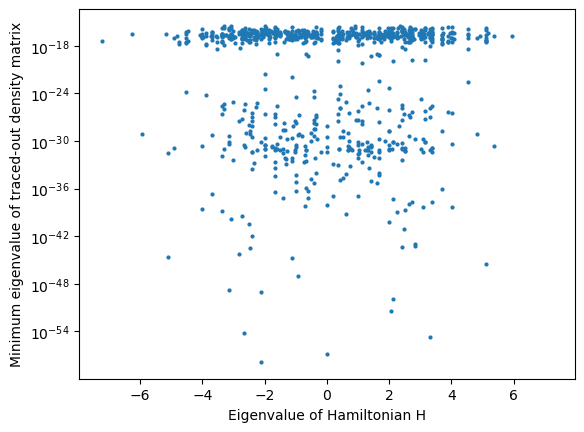

In [37]:
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, np.abs(min_eigenvalues), 'o', markersize=2)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
#plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()